In [ ]:
from sklearn.cluster import KMeans
import numpy as np
import scipy as sp
import sys
sys.path.append('../corv/src')
sys.path.append('../wdtools')

import matplotlib.pyplot as plt
import matplotlib.colors as colors
from astropy.io import fits
from astropy.table import Table
from tqdm import tqdm
import pandas as pd
import corv

### Query
from astroquery.sdss import SDSS
from astroquery.gaia import Gaia
from astropy import constants as c
import data_selector as ds

import wdtools


In [ ]:
catalog = Table.read('data/01_catalog.fits')

In [17]:
i = 3
print(catalog['id'][i].split('_')[1].split('-'))

['51788', '0386', '0258*']


In [18]:
plate = []
mjd = []
fiber = []

for i in range(len(catalog)):
    try:
        mjd.append(int(catalog['id'][i].split('_')[1].split('-')[0]))
        plate.append(int(catalog['id'][i].split('_')[1].split('-')[1]))
        fiber.append(int(catalog['id'][i].split('_')[1].split('-')[2][:3]))
    except:
        print(i)
        a = int('342F#')
    


In [19]:
spec = []
wl = []
fl = []
ivar = []

for i in tqdm(range(len(catalog))):
    try:
        spec.append(SDSS.get_spectra_async(plate=plate[i], fiberID=fiber[i], mjd=mjd[i])[0].get_fits())
        
        wl.append(10**spec[i][1].data['loglam'])
        fl.append(spec[i][1].data['flux'])
        ivar.append(spec[i][1].data['ivar'])
    except:
        spec.append(-9999)
        wl.append(-9999)
        fl.append(-9999)
        ivar.append(-9999)
        
        
catalog['wd_spectrum'] = spec
catalog['wd_wl'] = wl
catalog['wd_fl'] = fl
catalog['wd_ivar'] = ivar
    
print(type(spec[0]))

  1%|▋                                                                          | 1/101 [00:00<00:52,  1.90it/s]/home/arseneausm/anaconda3/lib/python3.8/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),
100%|█████████████████████████████████████████████████████████████████████████| 101/101 [00:07<00:00, 13.41it/s]


<class 'astropy.io.fits.hdu.hdulist.HDUList'>


In [20]:
print(spec[0][1].header)

XTENSION= 'BINTABLE'           / binary table extension                         BITPIX  =                    8 / array data type                                NAXIS   =                    2 / number of array dimensions                     NAXIS1  =                   32 / length of dimension 1                          NAXIS2  =                 3817 / length of dimension 2                          PCOUNT  =                    0 / number of group parameters                     GCOUNT  =                    1 / number of groups                               TFIELDS =                    8 / number of table fields                         TTYPE1  = 'flux    '                                                            TFORM1  = 'E       '                                                            TTYPE2  = 'loglam  '                                                            TFORM2  = 'E       '                                                            TTYPE3  = 'ivar    '                    

In [22]:
def pseudonormalize(fl, win = 50):
    cont_fl = np.repeat(np.nan, len(fl))
    
    for i in range(len(fl)):
        if (i - (win / 2)) < 0:
            fl_win = fl[0:(i + (win // 2))]
        else:
            fl_win = fl[(i - (win // 2)) : (i + (win // 2))]
        
        cont_fl[i] = np.percentile(fl_win, 90)
        
    return fl / cont_fl
'''
def spec_split(bands, wl, fl, window_size = 100):
    spec_split = {}
    
    for i in range(len(bands)):
        spec_split[bands.keys()[i]] = np.array([ [wl[
'''

'\ndef spec_split(bands, wl, fl, window_size = 100):\n    spec_split = {}\n    \n    for i in range(len(bands)):\n        spec_split[bands.keys()[i]] = np.array([ [wl[\n'

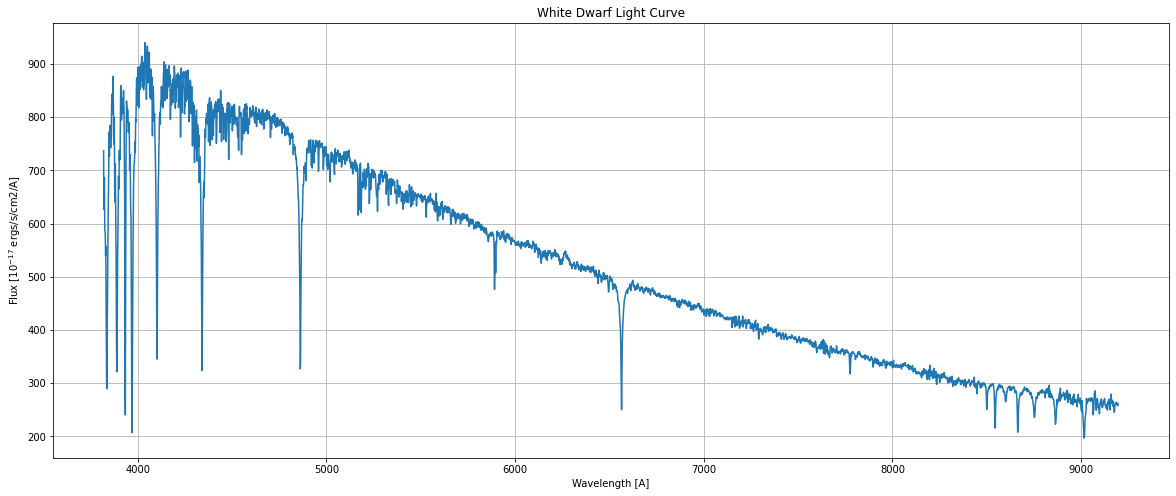

In [23]:
i = 0

plt.figure(figsize=(20,8))

plt.plot(wl[i], fl[i])
plt.grid()
plt.ylabel(r'Flux [$10^{-17}$ ergs/s/cm2/A]')
plt.xlabel(r'Wavelength [A]')
plt.title('White Dwarf Light Curve')
ax = plt.gca()

plt.show()

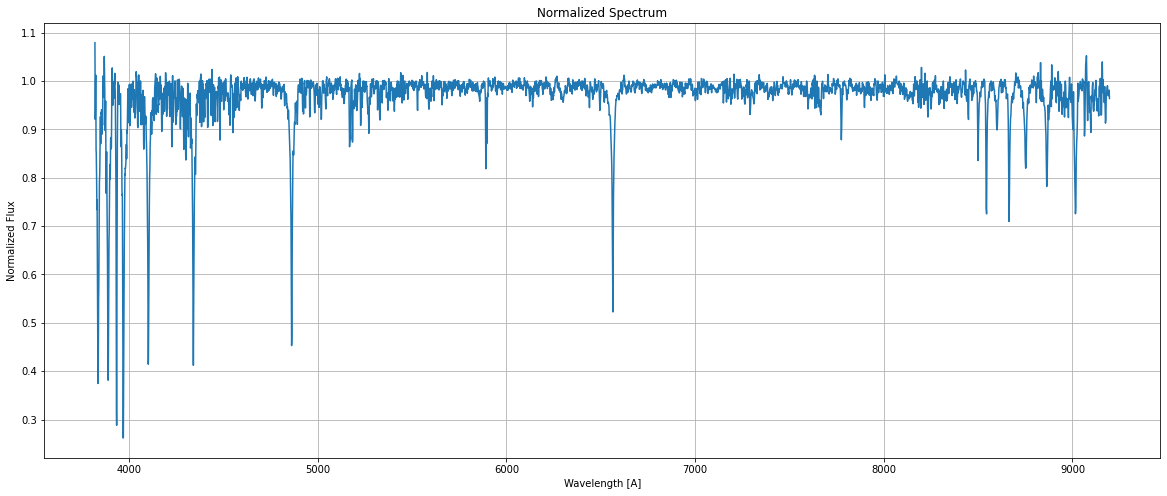

In [24]:
nwl = wl[i]
nfl = fl[i]
cont = pseudonormalize(nfl, 50)

plt.figure(figsize=(20,8))

plt.plot(nwl, cont)
plt.grid()
plt.ylabel(r'Normalized Flux')
plt.xlabel(r'Wavelength [A]')
plt.title('Normalized Spectrum')
ax = plt.gca()

plt.show()

$v_g = \frac{GM}{Rc}$ 

$logg = log \left( - \frac{GM}{R^2} \right)$

$\frac{cv_g}{-10^{log g}} = \frac{cv_g}{-g} = \frac{cGM}{Rc} \frac{R^2}{GM} = R$ 

  0%|                                                                                   | 0/101 [00:00<?, ?it/s]

fitting radial velocity...
fitting continuum...
Radial Velocity = -25 ± 2 km/s
final optimization...
initializing at teff = 8000 K
initializing at teff = 21500 K
initializing at teff = 35000 K
burning in chains...
sampling posterior...
logg is near bound of the model grid! exercise caution with this result


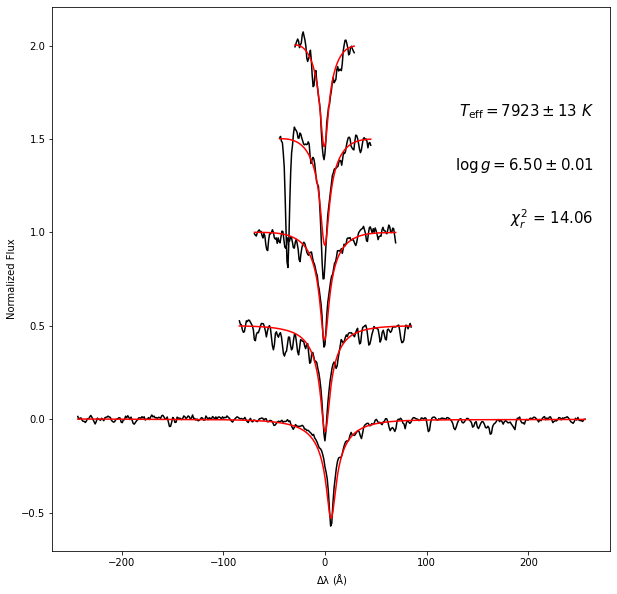

  1%|▋                                                                        | 1/101 [01:13<2:03:12, 73.92s/it]

fitting radial velocity...
fitting continuum...
Radial Velocity = -675 ± 393 km/s
final optimization...
initializing at teff = 8000 K
initializing at teff = 21500 K
initializing at teff = 35000 K
burning in chains...


Traceback (most recent call last):
  File "/home/arseneausm/anaconda3/lib/python3.8/site-packages/emcee-3.1.2-py3.8.egg/emcee/ensemble.py", line 624, in __call__
    return self.f(x, *self.args, **self.kwargs)
  File "/home/arseneausm/anaconda3/lib/python3.8/site-packages/wdtools-0.4-py3.8.egg/wdtools/gfp.py", line 451, in lnprob
    return lp + lnlike(prms)
  File "/home/arseneausm/anaconda3/lib/python3.8/site-packages/wdtools-0.4-py3.8.egg/wdtools/gfp.py", line 424, in lnlike
    model = self.spectrum_sampler(wl, *prms)
  File "/home/arseneausm/anaconda3/lib/python3.8/site-packages/wdtools-0.4-py3.8.egg/wdtools/gfp.py", line 243, in spectrum_sampler
    synth = self.synth_spectrum_sampler(self.lamgrid[specclass], teff, logg, rv, specclass)
  File "/home/arseneausm/anaconda3/lib/python3.8/site-packages/wdtools-0.4-py3.8.egg/wdtools/gfp.py", line 206, in synth_spectrum_sampler
    synth = self.model[specclass].predict(label)[0]
  File "/home/arseneausm/anaconda3/lib/python3.8/site-pack

emcee: Exception while calling your likelihood function:
  params: [3.99750927e+04 6.50912514e+00]
  args: []
  kwargs: {}
  exception:




KeyboardInterrupt



In [27]:
gfp = wdtools.GFP(resolution = 2, specclass = 'DA')

teff = []
e_teff = []
logg = []
e_logg = []
redchis = []

for i in tqdm (range(len(catalog))):
    labels, e_labels, redchi = gfp.fit_spectrum(catalog['wd_wl'][i], catalog['wd_fl'][i], catalog['wd_ivar'][i],
                                mcmc = True, nwalkers = 25, burn = 50, ndraws = 50,
                                progress = False,
                                lines = ['beta', 'gamma', 'delta', 'eps', 'h8'])
    
    teff.append(labels[0])
    e_teff.append(e_labels[0])
    
    logg.append(labels[1])
    e_logg.append(e_labels[1])
    
    redchis.append(redchi)
    
catalog['teff'] = teff
catalog['e_teff'] = e_teff

catalog['logg'] = logg
catalog['e_logg'] = e_logg

catalog['redchi'] = redchis

In [ ]:
c = 3e8

catalog['radius'] = c * catalog['g_redshift'] / (-10**catalog['logg'])